In [1]:
if (!requireNamespace("dplyr", quietly = TRUE)) {
    install.packages("dplyr")
}

# ---- Update or install Hipathia ----
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

# Install or update the 'hipathia' package from Bioconductor
BiocManager::install("hipathia", ask = FALSE, update = TRUE)

# Check the installed package version
packageVersion("hipathia")


'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.r-project.org

Bioconductor version 3.20 (BiocManager 1.30.26), R 4.4.3 (2025-02-28)

Warning message:
“package(s) not installed when version(s) same as or greater than current; use
  `force = TRUE` to re-install: 'hipathia'”
Old packages: 'Biostrings', 'digest', 'gower', 'IRanges', 'mgcv', 'purrr',
  'rbibutils', 'reshape2', 'RSQLite', 'SparseArray'

Warning message in install.packages(update[instlib == l, "Package"], l, contriburl = contriburl, :
“installation of package ‘digest’ had non-zero exit status”
Warning message in install.packages(update[instlib == l, "Package"], l, contriburl = contriburl, :
“installation of package ‘gower’ had non-zero exit status”
Warning message in install.packages(update[instlib == l, "Package"], l, contriburl = contriburl, :
“installation of package ‘IRanges’ had non-zero ex

[1] ‘3.6.0’

In [2]:
library(dplyr)
library(hipathia)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: igraph


Attaching package: ‘igraph’


The following objects are masked from ‘package:dplyr’:

    as_data_frame, groups, union


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union


Loading required package: AnnotationHub

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:igraph’:

    normalize, path, union


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, base

In [3]:
## ==============================
## PARAMETERS
## ==============================

# Input files
rna_path  <- "rna_data_filtered wtumor.csv"          # raw RNA matrix (csv or tsv)
meta_path <- "complet_cell_metadata_grouped.csv"   # cleaned metadata with 'cell_id' and 'group'

# Output files
rna_standardized_out <- "rna_standardized.csv"   # standardized Gene × Cells
expr_pseudobulk_out  <- "expr_pseudobulk_symbols.csv" # Gene × Samples after pseudobulk
design_out           <- "design.csv"             # SampleID × Group (Tumor/Normal)

# Options
pseudobulk_method <- "sum"   # "mean" for normalized data, "sum" if raw counts
min_overlap_prop  <- 0.9      # threshold for barcode overlap warning

#Pathaways
species <- "hsa"
pathways_list <- c()   # exampel: c("hsa03320", "hsa04014") 
                       # or empty: c()



In [4]:
## ==============================
## RNA Reader + Standardizer
## ==============================

## ---- Helper functions
read_tab <- function(p) {
  if (grepl("\\.tsv$", p, ignore.case = TRUE)) {
    read.delim(p, stringsAsFactors = FALSE, check.names = FALSE)
  } else if (grepl("\\.csv$", p, ignore.case = TRUE)) {
    read.csv(p, stringsAsFactors = FALSE, check.names = FALSE)
  } else stop("Unknown format: expecting .csv or .tsv, got: ", p)
}

looks_barcode <- function(x) {
  grepl("[-_]", x) | grepl("-\\d+$", x)
}

looks_gene_symbol <- function(v) {
  v <- as.character(v)
  all(!grepl("-", v, fixed = TRUE)) &&
    mean(grepl("[A-Za-z]", v), na.rm = TRUE) > 0.6 &&
    mean(!grepl("^\\d+$", v), na.rm = TRUE) > 0.9
}

is_strict_index_col <- function(v) {
  v <- suppressWarnings(as.numeric(v))
  if (all(is.na(v))) return(FALSE)
  n <- length(v)
  sum(!is.na(v)) == n && identical(v, seq_len(n))
}

trim_all <- function(df) {
  names(df) <- trimws(names(df))
  for (j in seq_along(df)) if (is.character(df[[j]])) df[[j]] <- trimws(df[[j]])
  df
}

## ---- Read file
rna_raw <- read_tab(rna_path)
rna_raw <- trim_all(rna_raw)

empty_cols <- which(sapply(rna_raw, function(col) all(is.na(col) | col == "")))
if (length(empty_cols)) rna_raw <- rna_raw[ , -empty_cols, drop = FALSE]

stopifnot(ncol(rna_raw) >= 2)

## ---- Detect format
cn <- colnames(rna_raw)

drop_first <- FALSE
if (is_strict_index_col(rna_raw[[1]]) || toupper(cn[1]) %in% c("X","INDEX","ROW","IDS","ID")) {
  drop_first <- TRUE
}

rna1 <- if (drop_first) rna_raw[, -1, drop = FALSE] else rna_raw
cn1 <- colnames(rna1)

gene_col_idx <- NA_integer_
cand_idx <- seq_len(min(2, ncol(rna1)))
for (k in cand_idx) {
  samp <- head(rna1[[k]], 200)
  if (looks_gene_symbol(samp)) { gene_col_idx <- k; break }
}

transposed <- FALSE
if (is.na(gene_col_idx)) {
  prop_barcode_in_colnames <- mean(looks_barcode(cn1))
  prop_barcode_in_firstcol <- mean(looks_barcode(head(rna1[[1]], 200)))
  if (!is.na(prop_barcode_in_firstcol) && prop_barcode_in_firstcol > 0.6 &&
      !is.na(prop_barcode_in_colnames) && prop_barcode_in_colnames < 0.4) {
    transposed <- TRUE
  } else {
    gene_col_idx <- 1L
  }
}

## ---- Transpose if needed
if (transposed) {
  message("Detected transposed file (barcodes in rows). Transposing ...")
  barcodes <- as.character(rna1[[1]])
  mat <- as.data.frame(t(rna1[, -1, drop = FALSE]), stringsAsFactors = FALSE, check.names = FALSE)
  colnames(mat) <- barcodes
  mat <- cbind(Gene = rownames(mat), mat, row.names = NULL, check.names = FALSE)
  rna2 <- mat
} else {
  if (is.na(gene_col_idx)) gene_col_idx <- 1L
  colnames(rna1)[gene_col_idx] <- "Gene"
  rna2 <- rna1
}

## ---- Clean up
cn2 <- colnames(rna2)
if (!"Gene" %in% cn2) stop("Could not determine 'Gene' column. Please check file.")

barcode_cols <- setdiff(cn2, "Gene")

for (bc in barcode_cols) {
  if (is.character(rna2[[bc]])) {
    rna2[[bc]] <- gsub(",+$", "", rna2[[bc]])
  }
}
for (bc in barcode_cols) {
  rna2[[bc]] <- suppressWarnings(as.numeric(rna2[[bc]]))
}

rna2$Gene <- as.character(rna2$Gene)
rna2 <- rna2[!is.na(rna2$Gene) & rna2$Gene != "", , drop = FALSE]

if (any(duplicated(rna2$Gene))) {
  message("Duplicate gene names found -> aggregating by mean.")
  rna2 <- stats::aggregate(. ~ Gene, data = rna2, FUN = function(x) mean(as.numeric(x), na.rm = TRUE))
}

for (bc in barcode_cols) {
  nas <- is.na(rna2[[bc]])
  if (any(nas)) rna2[[bc]][nas] <- 0
}

## ---- Write standardized file
write.csv(rna2, rna_standardized_out, row.names = FALSE)
message("rna_standardized.csv written: column 'Gene' + ", length(barcode_cols), " barcode columns.")

## ---- Optional: check overlap with metadata
if (file.exists(meta_path)) {
  meta <- tryCatch(read.csv(meta_path, stringsAsFactors = FALSE, check.names = FALSE), error = function(e) NULL)
  if (!is.null(meta) && "cell_id" %in% colnames(meta)) {
    meta_ids <- trimws(as.character(meta$cell_id))
    cols <- setdiff(colnames(rna2), "Gene")
    in_both <- intersect(meta_ids, cols)
    prop <- if (length(cols) == 0) 0 else length(in_both) / length(cols)
    cat("\n===== Barcode-Check (optional) =====\n")
    cat("Barcodes in RNA (columns): ", length(cols), "\n", sep = "")
    cat("Barcodes in Metadata:      ", length(meta_ids), "\n", sep = "")
    cat("Overlap:                   ", length(in_both), " (", sprintf("%.2f", 100*prop), "%)\n", sep = "")
    if (prop < min_overlap_prop) {
      warning("Less than 90% overlap between RNA barcodes and Metadata cell_id. Check naming/subsetting.")
    } else {
      message("Barcode overlap OK (>=90%).")
    }
  } else {
    message("Metadata file present, but no 'cell_id' column found – skipping barcode check.")
  }
}


rna_standardized.csv written: column 'Gene' + 1000 barcode columns.




===== Barcode-Check (optional) =====
Barcodes in RNA (columns): 1000
Barcodes in Metadata:      84526
Overlap:                   1000 (100.00%)


Barcode overlap OK (>=90%).



In [5]:
## ==============================
## Pseudobulk (Cells -> Samples) + Design
## Uses:
##   - rna_standardized_out (Gene × Cells)
##   - meta_path (metadata with 'cell_id', 'orig.ident', 'group')
## Produces:
##   - expr_pseudobulk_out  (Gene × Samples)
##   - design_out           (sample_id, group)
## ==============================

# ---- Read inputs
rna_std <- read.csv(rna_standardized_out, stringsAsFactors = FALSE, check.names = FALSE)
meta    <- read.csv(meta_path,             stringsAsFactors = FALSE, check.names = FALSE)

# ---- Basic checks
if (!"Gene" %in% colnames(rna_std)) stop("Standardized RNA must contain column 'Gene'.")
if (!"cell_id" %in% colnames(meta)) stop("Metadata must contain column 'cell_id'.")
if (!"orig.ident" %in% colnames(meta)) stop("Metadata must contain column 'orig.ident'.")
if (!"group" %in% colnames(meta)) stop("Metadata must contain column 'group' (Tumor/Normal).")

# ---- Align RNA barcodes (columns) with metadata cell_id
rna_barcodes <- setdiff(colnames(rna_std), "Gene")
meta_ids     <- trimws(as.character(meta$cell_id))
keep_cells   <- intersect(rna_barcodes, meta_ids)

if (length(keep_cells) == 0) {
  stop("No overlap between RNA barcodes and metadata cell_id.")
}

# Subset RNA to overlapping cells (keep Gene column)
rna_sub <- rna_std[, c("Gene", keep_cells), drop = FALSE]

# ---- Build mapping: cell_id -> orig.ident (sample) + group
meta_map <- meta[match(keep_cells, meta$cell_id), c("cell_id","orig.ident","group")]
colnames(meta_map) <- c("cell_id","sample_id","group")

# ---- Convert RNA to numeric matrix (cells only)
mat <- as.matrix(rna_sub[, -1, drop = FALSE])
mode(mat) <- "numeric"
rownames(mat) <- rna_sub$Gene

# ---- Aggregate per sample_id (orig.ident)
samples <- unique(meta_map$sample_id)

agg_one <- function(smpl) {
  cols <- which(meta_map$sample_id == smpl)
  if (length(cols) == 1L) {
    mat[, cols, drop = FALSE]
  } else {
    if (tolower(pseudobulk_method) == "sum") {
      matrix(rowSums(mat[, cols, drop = FALSE], na.rm = TRUE), ncol = 1,
             dimnames = list(rownames(mat), smpl))
    } else {
      matrix(rowMeans(mat[, cols, drop = FALSE], na.rm = TRUE), ncol = 1,
             dimnames = list(rownames(mat), smpl))
    }
  }
}

pb_list <- lapply(samples, agg_one)
pb_mat  <- do.call(cbind, pb_list)

# ---- Build pseudobulk dataframe
expr_pseudobulk <- data.frame(Gene = rownames(pb_mat), pb_mat, check.names = FALSE)

# ---- Collapse duplicated genes (mean)
if (any(duplicated(expr_pseudobulk$Gene))) {
  expr_pseudobulk <- aggregate(. ~ Gene, data = expr_pseudobulk, FUN = function(x) mean(as.numeric(x), na.rm = TRUE))
}

## ---- Build design: one row per sample_id, assign group by majority vote (Base R version)
design <- aggregate(group ~ sample_id, data = meta_map, FUN = function(x) {
  if (mean(x == "Tumor", na.rm = TRUE) >= 0.5) "Tumor" else "Normal"
})

# ---- Write outputs
write.csv(expr_pseudobulk, expr_pseudobulk_out, row.names = FALSE)
write.csv(design,           design_out,          row.names = FALSE)

# ---- Report
cat("\n===== PSEUDOBULK DONE =====\n")
cat("Samples (orig.ident): ", paste(colnames(expr_pseudobulk)[-1], collapse = ", "), "\n", sep = "")
cat("Genes (rows):         ", nrow(expr_pseudobulk), "\n", sep = "")
cat("Design rows:          ", nrow(design), "\n", sep = "")
cat("Files written:        ", expr_pseudobulk_out, ", ", design_out, "\n", sep = "")



===== PSEUDOBULK DONE =====
Samples (orig.ident): p786pos, p786neg, p811, p826, p846, p848, p4, p8pos, p8neg, p7, p9, p10, p11, p12, p13
Genes (rows):         31915
Design rows:          15
Files written:        expr_pseudobulk_symbols.csv, design.csv


In [6]:
## ==============================
## Step 1: Map Gene Symbols to Entrez IDs  (fixed root version)
## ==============================

# Install Bioconductor annotation package if missing
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

if (!requireNamespace("org.Hs.eg.db", quietly = TRUE))
    BiocManager::install("org.Hs.eg.db")

# Load library
library(org.Hs.eg.db)

# Read pseudobulk matrix (symbols)
expr_pb <- read.csv(expr_pseudobulk_out, stringsAsFactors = FALSE, check.names = FALSE)

# Check
if (!"Gene" %in% colnames(expr_pb)) stop("Expression file must contain column 'Gene'.")

# Map Gene Symbols -> Entrez IDs
gene_symbols <- expr_pb$Gene
entrez_ids <- mapIds(org.Hs.eg.db,
                     keys = gene_symbols,
                     column = "ENTREZID",
                     keytype = "SYMBOL",
                     multiVals = "first")

# Add Entrez IDs
expr_pb$EntrezID <- entrez_ids

# Remove genes without mapping
expr_pb <- expr_pb[!is.na(expr_pb$EntrezID), ]

# Collapse duplicates (mean per EntrezID)
expr_pb <- aggregate(. ~ EntrezID, data = expr_pb[, c("EntrezID", setdiff(colnames(expr_pb), c("Gene", "EntrezID")))],
                     FUN = function(x) if (is.numeric(x)) mean(as.numeric(x), na.rm = TRUE) else x[1])

# Use EntrezID as rownames
rownames(expr_pb) <- expr_pb$EntrezID

# Remove redundant column
expr_pb$EntrezID <- NULL

# Save clean expression matrix
write.csv(expr_pb, "expr_pseudobulk_entrez.csv", row.names = TRUE)

# Report
cat("\n===== MAPPING DONE (fixed root version) =====\n")
cat("Input genes (symbols): ", length(gene_symbols), "\n", sep = "")
cat("Mapped to Entrez IDs : ", nrow(expr_pb), "\n", sep = "")
cat("File written: expr_pseudobulk_entrez.csv\n")




Loading required package: AnnotationDbi


Attaching package: ‘AnnotationDbi’


The following object is masked from ‘package:dplyr’:

    select


'select()' returned 1:many mapping between keys and columns




===== MAPPING DONE (fixed root version) =====
Input genes (symbols): 31915
Mapped to Entrez IDs : 22374
File written: expr_pseudobulk_entrez.csv


In [7]:
#3.1
library(hipathia)

trans_data <- as.matrix(read.csv("expr_pseudobulk_entrez.csv",
                                 row.names = 1, check.names = FALSE))



In [8]:
#3.2
# exakt der Vignetten-Schritt:
exp_data <- normalize_data(trans_data, by_quantiles = FALSE)

write.csv(data.frame(Gene=rownames(exp_data), exp_data, check.names=FALSE),
          "Vinette_Like_RNA-Data.csv", row.names=FALSE)


Quantile normalization failed (preprocessCore). Using truncation_percentil = 0.95.



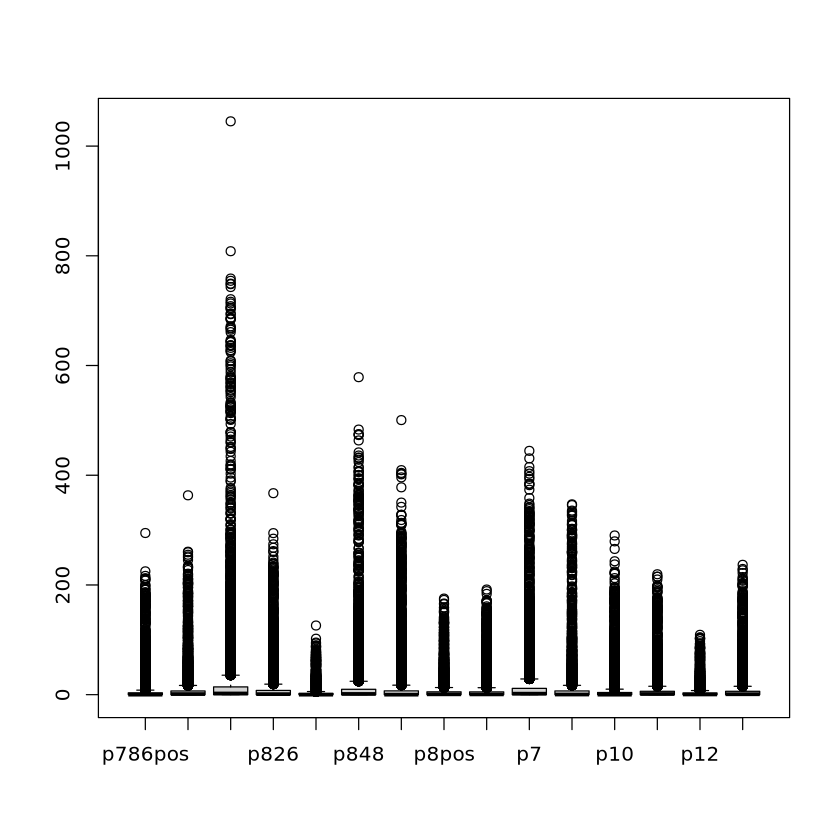

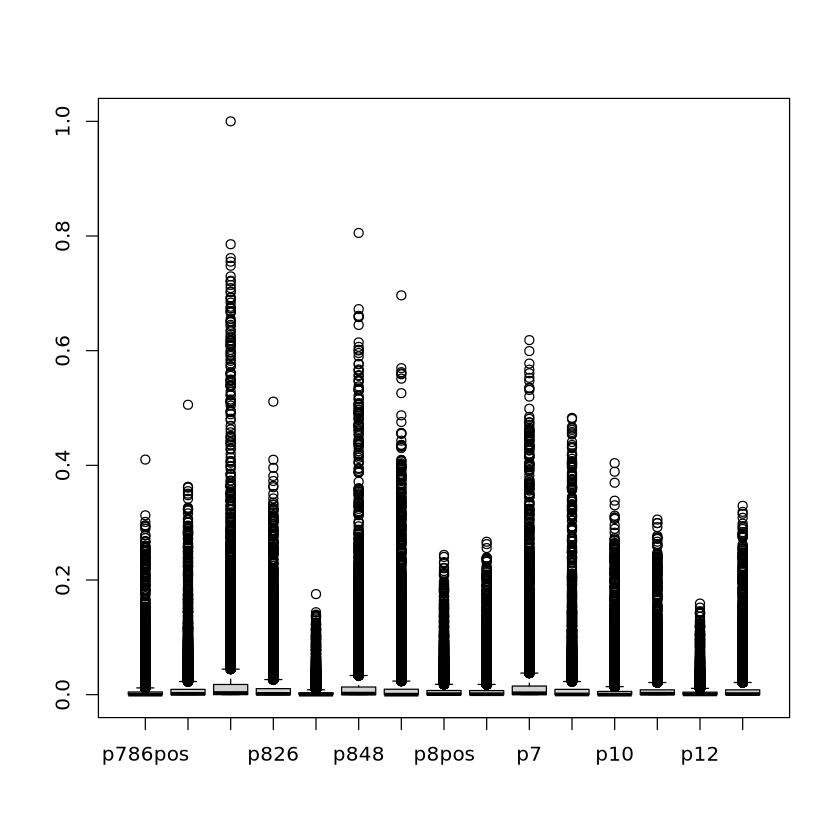

In [9]:
# vor Scaling
boxplot(trans_data)

# Limit threads (verhindert pthread-Fehler auf Clustern)
Sys.setenv(OMP_NUM_THREADS="1", MKL_NUM_THREADS="1",
           OPENBLAS_NUM_THREADS="1", VECLIB_MAXIMUM_THREADS="1")

# Versuche Quantile-Norm, sonst nimm Truncation wie in der Vignette
exp_data <- tryCatch(
  normalize_data(trans_data, by_quantiles = TRUE),
  error = function(e) {
    message("Quantile normalization failed (preprocessCore). Using truncation_percentil = 0.95.")
    normalize_data(trans_data, truncation_percentil = 0.95)
  }
)

boxplot(exp_data)


In [10]:
#4.1
if (length(pathways_list) == 0) {
    message("No pathway list provided -> loading ALL pathways for ", species)
    pathways <- load_pathways(species = species)
} else {
    message("Loading subset of pathways: ", paste(pathways_list, collapse = ", "))
    pathways <- load_pathways(species = species, pathways_list = pathways_list)
}

# ---- Check
length(pathways)   # Anzahl geladener Pathways
names(pathways)[1:5]  # Erste 5 Pathways anzeigen
get_pathways_list(pathways)[1:10]

No pathway list provided -> loading ALL pathways for hsa

Loaded 146 pathways



[1] 7

[1] "species"     "all.genes"   "path.norm"   "eff.norm"    "pathigraphs"

[1] "hsa03320" "hsa03460" "hsa04010" "hsa04012" "hsa04014" "hsa04015"
 [7] "hsa04020" "hsa04022" "hsa04024" "hsa04062"

In [11]:
#4.3 Using Hipathia to comute the signal
results <- hipathia(exp_data, pathways, decompose = FALSE, verbose=FALSE)
## Added missing genes: 165 (4.93%)

Added missing genes: 55 (0.25%)



In [12]:
#4.3 Using Hipathia to comute the signal
results

A MultiAssayExperiment object of 2 listed
 experiments with user-defined names and respective classes.
 Containing an ExperimentList class object of length 2:
 [1] nodes: SummarizedExperiment with 6826 rows and 15 columns
 [2] paths: SummarizedExperiment with 1876 rows and 15 columns
Functionality:
 experiments() - obtain the ExperimentList instance
 colData() - the primary/phenotype DataFrame
 sampleMap() - the sample coordination DataFrame
 `$`, `[`, `[[` - extract colData columns, subset, or experiment
 *Format() - convert into a long or wide DataFrame
 assays() - convert ExperimentList to a SimpleList of matrices
 exportClass() - save data to flat files

In [13]:
#4.3 Using Hipathia to comute the signal
path_vals <- get_paths_data(results)
hhead(path_vals, 4)

,p786pos,p786neg,p811,p826
P-hsa03320-37,0,0.000000e+00,0,0
P-hsa03320-61,0,7.350786e-06,0,0
P-hsa03320-46,0,0.000000e+00,0,0
P-hsa03320-57,0,0.000000e+00,0,0


In [14]:
#5 Function activation computation
uniprot_vals <- quantify_terms(results, pathways, dbannot = "uniprot")

go_vals <- quantify_terms(results, pathways, dbannot = "GO")
#142/1654 soll so sein

Quantified Uniprot terms: 142

Quantified GO terms: 1654



In [15]:
#6.1  Two classes comparison
design <- read.csv(meta_path, stringsAsFactors = FALSE, check.names = FALSE)
design <- design[!duplicated(design$orig.ident), c("orig.ident","group")]
rownames(design) <- design$orig.ident

sample_group <- design[colnames(path_vals), "group"]
comp <- do_wilcoxon(path_vals[, names(sample_group), drop = FALSE], sample_group, g1 = "Tumor", g2 = "Normal")
head(comp)


,UP/DOWN,statistic,p.value,FDRp.value
,<chr>,<dbl>,<dbl>,<dbl>
P-hsa03320-37,DOWN,-3.061862,1,1
P-hsa03320-61,DOWN,-3.061862,1,1
P-hsa03320-46,DOWN,-3.061862,1,1
P-hsa03320-57,DOWN,-3.061862,1,1
P-hsa03320-64,DOWN,-3.061862,1,1
P-hsa03320-47,DOWN,-3.061862,1,1


In [16]:
#6.1  Two classes comparison
pathways_summary <- get_pathways_summary(comp, pathways)
head(pathways_summary, 4)

,id_pathways,num_total_paths,num_significant_paths,percent_significant_paths,num_up_paths,percent_up_paths,num_down_paths,percent_down_paths
,<chr>,<int>,<int>,<dbl>,<int>,<dbl>,<int>,<dbl>
PPAR signaling pathway,hsa03320,42,0,0,0,0,0,0
Fanconi anemia pathway,hsa03460,7,0,0,0,0,0,0
MAPK signaling pathway,hsa04010,28,0,0,0,0,0,0
ErbB signaling pathway,hsa04012,18,0,0,0,0,0,0


In [17]:
#6.2 Pricipal Components ANalysis
ranked_path_vals <- path_vals[order(comp$p.value, decreasing = FALSE),]
pca_model <- do_pca(ranked_path_vals[1:ncol(ranked_path_vals),])

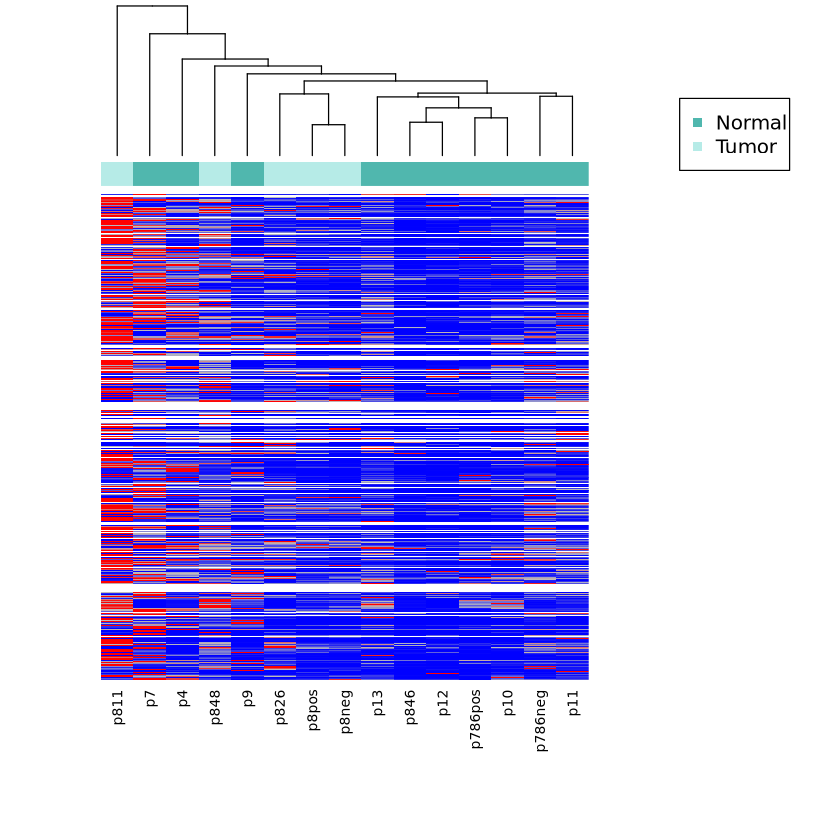

In [18]:
#7Heatmap
heatmap_plot(path_vals, group = sample_group)


In [19]:
# This should be TRUE; if FALSE, you sorted columns/rows inkonsistent
all(rownames(ranked_path_vals) %in% rownames(path_vals))
all(rownames(ranked_path_vals)[1:5] == rownames(comp)[order(comp$p.value, decreasing=FALSE, na.last=NA)][1:5])


[1] TRUE

[1] TRUE

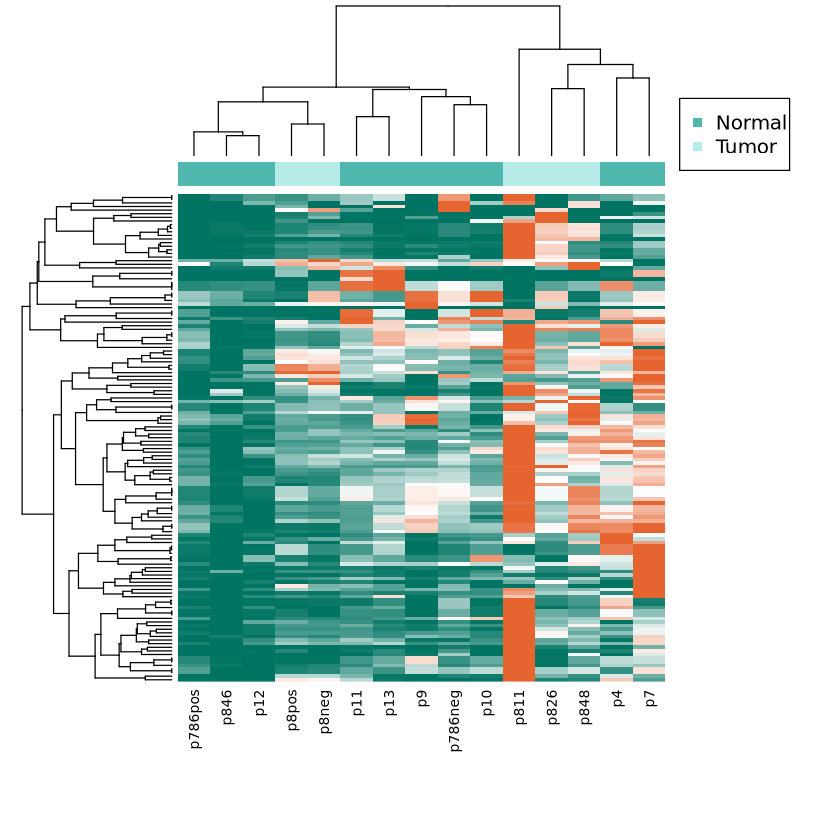

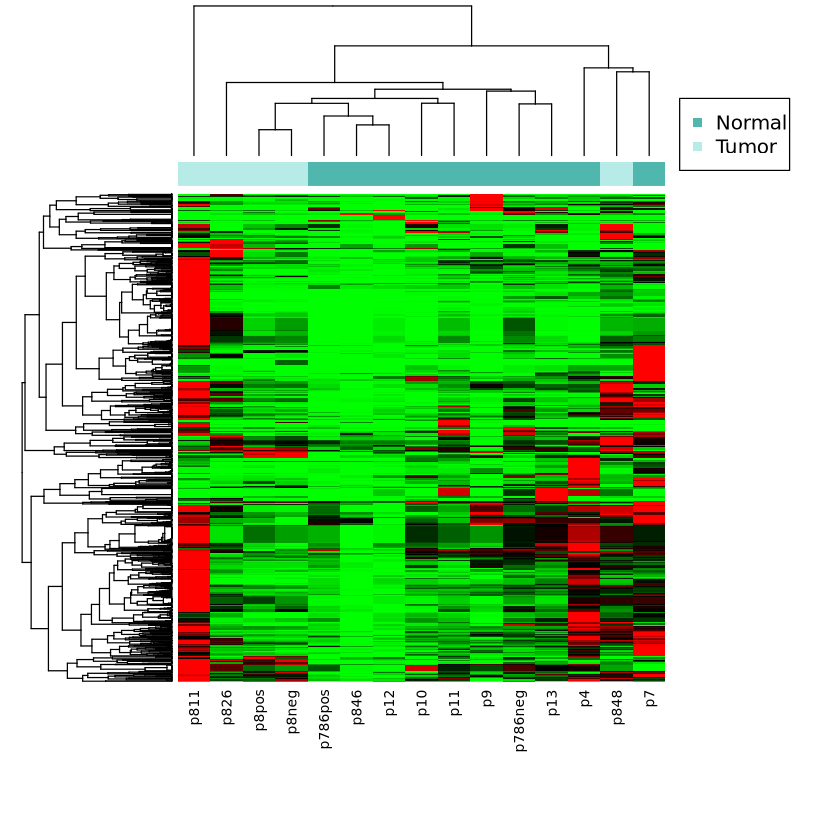

In [20]:
heatmap_plot(uniprot_vals, group = sample_group, colors="hipathia",
variable_clust = TRUE)
heatmap_plot(go_vals, group = sample_group, colors="redgreen",
variable_clust = TRUE)

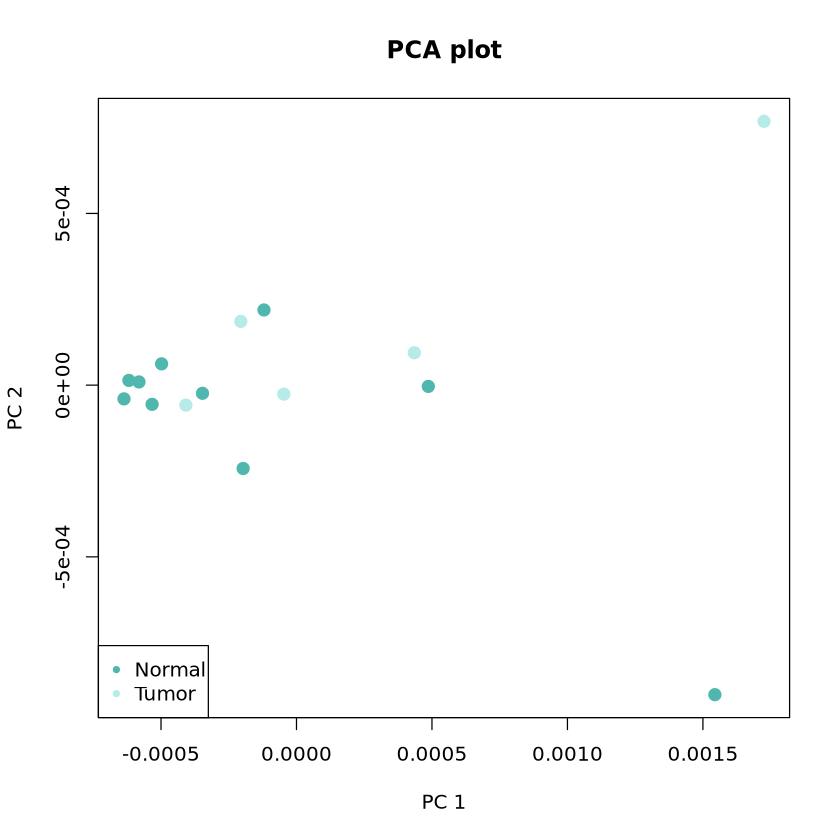

In [21]:
pca_plot(pca_model, sample_group, legend = TRUE)

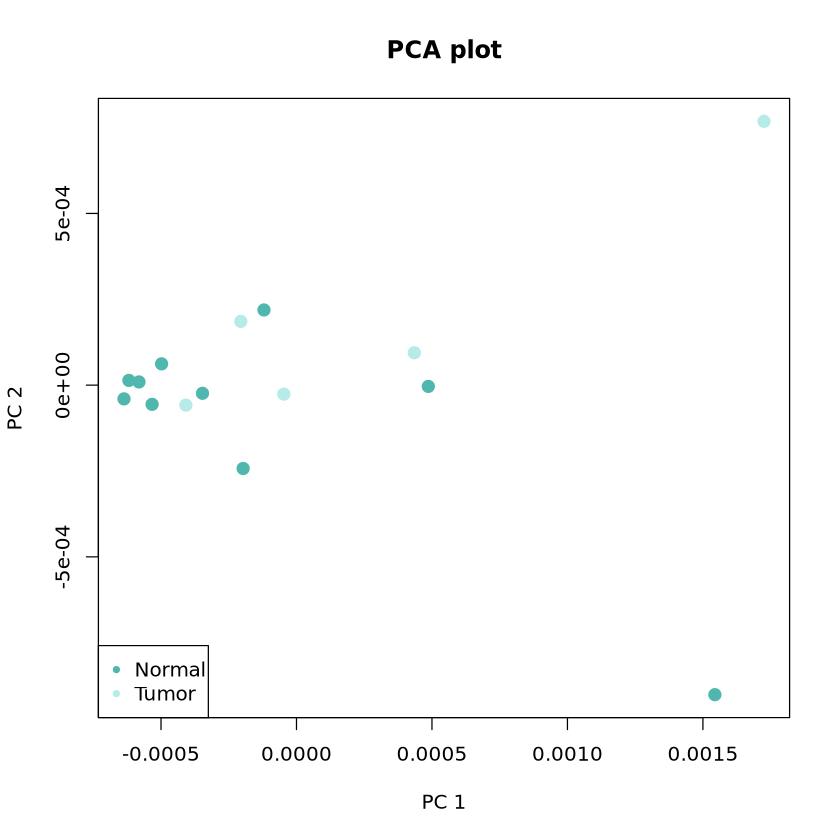

In [22]:
pca_plot(pca_model, sample_group, legend = TRUE)

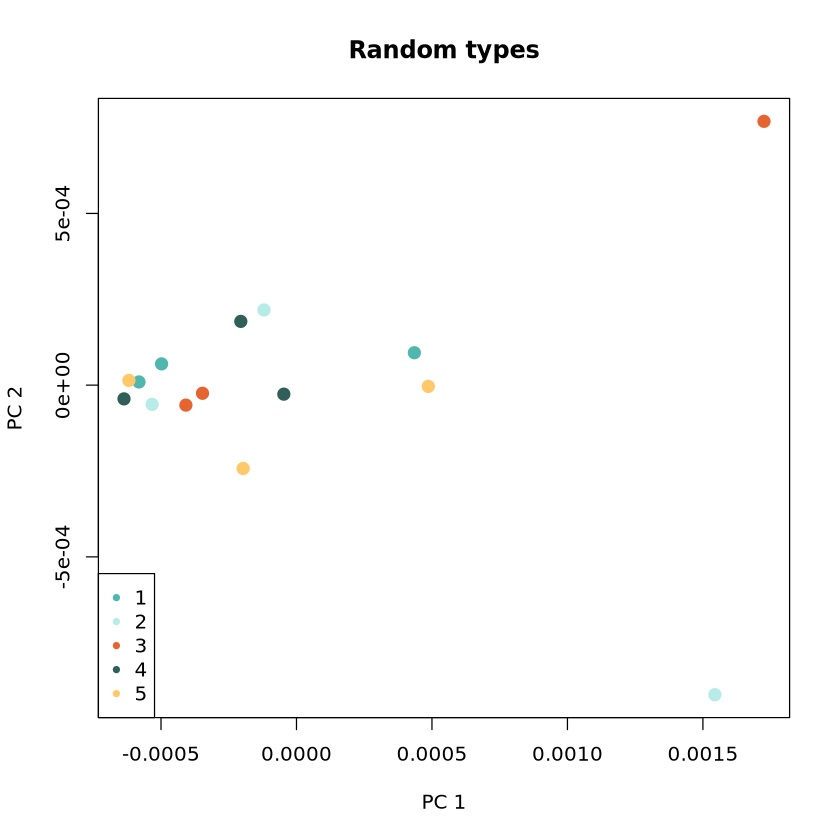

In [23]:

pca_plot(pca_model, group = rep(1:5, 8), main = "Random types",
legend = TRUE)

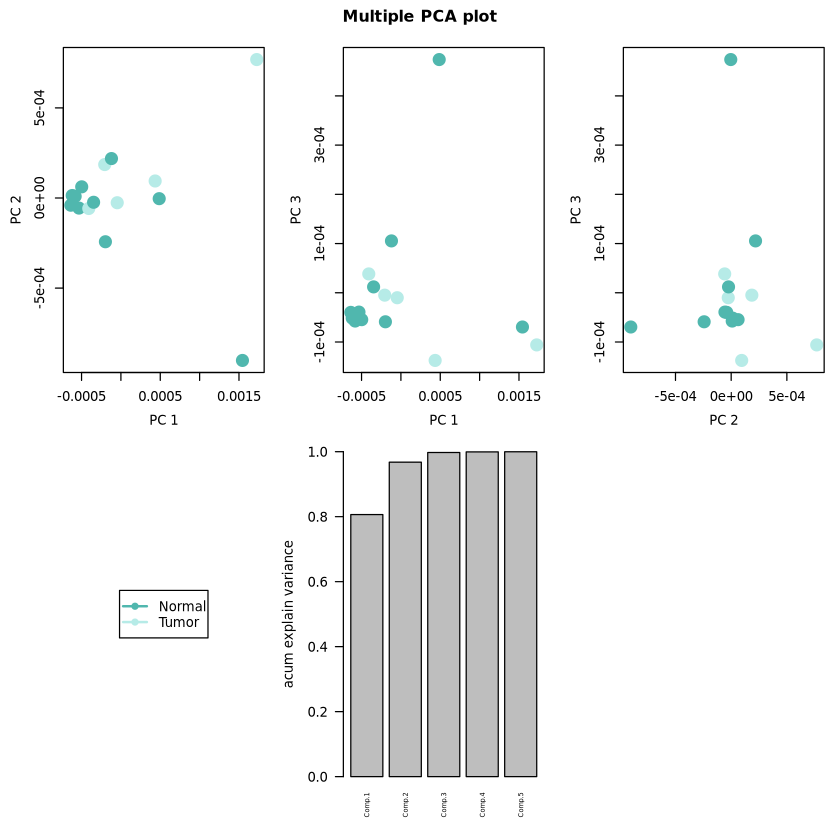

In [24]:
multiple_pca_plot(pca_model, sample_group, cex=3, plot_variance = TRUE)

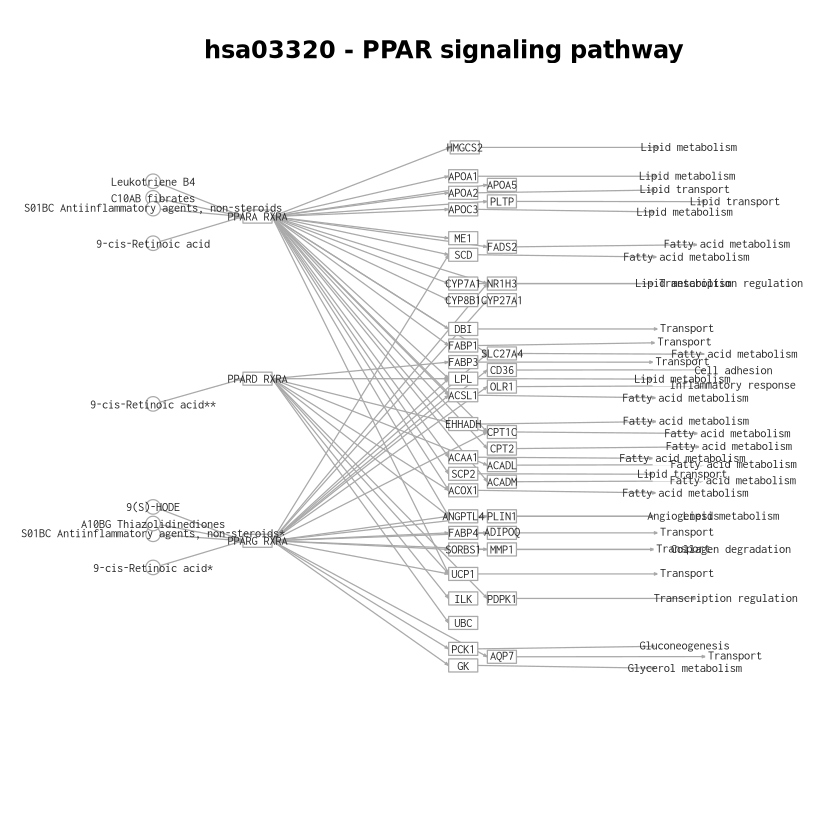

In [25]:
pathway_comparison_plot(comp, metaginfo = pathways, pathway = "hsa03320")

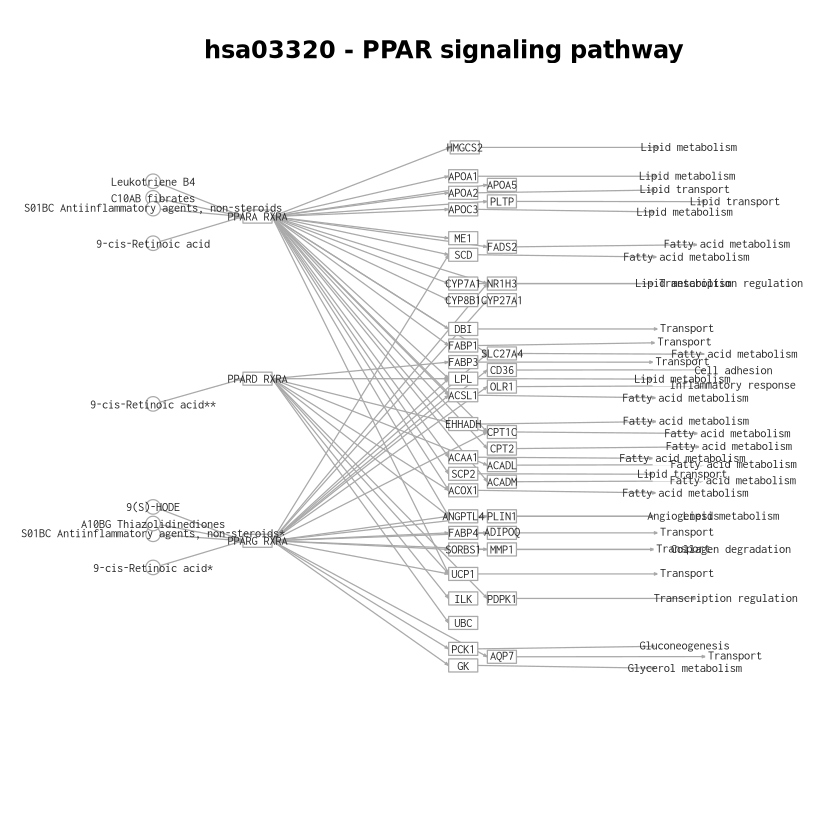

In [26]:
colors_de <- node_color_per_de(results, pathways, sample_group, "Tumor",
"Normal")
pathway_comparison_plot(comp, metaginfo = pathways, pathway = "hsa03320",
node_colors = colors_de)

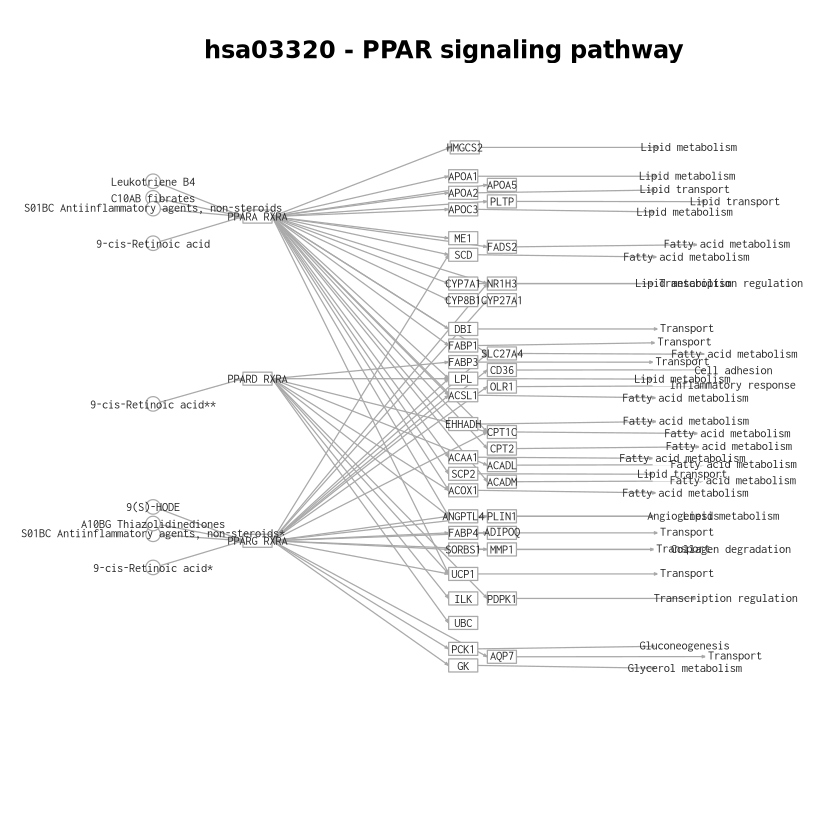

In [27]:
colors_de_hipathia <- node_color_per_de(results, pathways, sample_group,
"Tumor", "Normal", colors = "hipathia")
pathway_comparison_plot(comp, metaginfo = pathways, pathway = "hsa03320",
node_colors = colors_de_hipathia, colors = "hipathia")
pathway_comparison_plot(
  comp,
  metaginfo = pathways,
  pathway = "hsa03320",
  node_colors = colors_de_hipathia,
  colors = "hipathia",
)

In [28]:
#7.4. Vizualization through a local server
report <- create_report(comp, pathways, "save_noColors")
## Creating report folders...
## Creating pathways folder...
## Creating HTML index...
#report_colors <- create_report(comp, pathways, "save_colors",
#node_colors = colors_de)
## Creating report folders...
## Creating pathways folder...
## Creating HTML index...


Creating report folders...

Creating pathways folder...

Creating HTML index...



In [29]:

visualize_report(report, port = 4030)

Serving the directory /tmp/RtmpliXSbh/save_noColors/pathway-viewer at http://127.0.0.1:4030



Open a web browser and go to URL http://127.0.0.1:4030


In [30]:
# 1) alte servr-Prozesse beenden
if (requireNamespace("servr", quietly = TRUE)) {
  dl <- try(servr::daemon_list(), silent = TRUE)
  if (!inherits(dl, "try-error") && NROW(dl)) {
    for (i in dl$id) try(servr::daemon_stop(i), silent = TRUE)
  }
}

# 2) freien Port wählen
port <- servr::random_port()  # nimmt garantiert freien Port, z.B. 4010

# 3) Report visualisieren
visualize_report(report, port = port)


Serving the directory /tmp/RtmpliXSbh/save_noColors/pathway-viewer at http://127.0.0.1:4321



Open a web browser and go to URL http://127.0.0.1:4321


In [31]:
apply(trans_data, 2, sd)


p786pos   p786neg      p811      p826      p846      p848        p4     p8pos 
14.573355 18.309978 50.242254 20.926743  6.765775 31.062807 26.970872 12.228753 
    p8neg        p7        p9       p10       p11       p12       p13 
13.449482 28.929267 22.882379 15.691861 14.164397  7.322438 15.266706

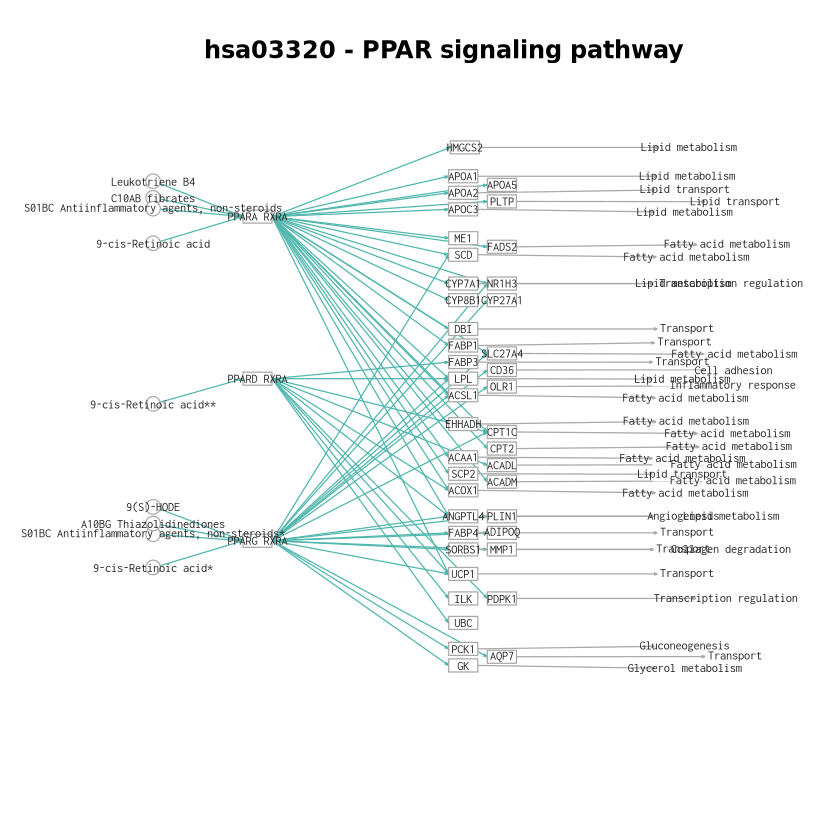

In [32]:
comp$FDRp.value <- runif(nrow(comp), 0, 0.01)  # zufällige kleine Werte
comp$UP.DOWN <- sample(c("UP","DOWN"), nrow(comp), replace = TRUE)

pathway_comparison_plot(
  comp,
  metaginfo = pathways,
  pathway = "hsa03320",
  node_colors = node_color_per_de(results, pathways, sample_group,
                                  "Tumor", "Normal", colors = "hipathia"),
  colors = "hipathia"
)


In [33]:
apply(trans_data, 2, sd)


p786pos   p786neg      p811      p826      p846      p848        p4     p8pos 
14.573355 18.309978 50.242254 20.926743  6.765775 31.062807 26.970872 12.228753 
    p8neg        p7        p9       p10       p11       p12       p13 
13.449482 28.929267 22.882379 15.691861 14.164397  7.322438 15.266706

In [34]:
table(design$group)



Normal  Tumor 
    10      5 

In [35]:
table(meta$group, meta$orig.ident)


        
           p10   p11   p12   p13    p4    p7 p786neg p786pos  p811  p826  p846
  Normal  4625  2636  1463  4700  7205  6596    5173    3387  3959   419  1362
  Tumor      0  1021  1143   116   330  2280     171       3 11618  4109    97
        
          p848 p8neg p8pos    p9
  Normal  3940    17   442  8284
  Tumor   3551  3427  2245   207